If we want to generate a classifier that observes the differences between two groups of protein seequences, then we need to extract numerical information from our sequences. This is called encoding and can be done through a variety of ways inlcuding residue level encoding of each amino acid in your sequences with a 1x20 vector, representing the possibility of 20 amino acids at each residue. This is called One Hot Encoding, but often leads to a sparse dataset which is not suitable for machine learning tasks and each sequence must be spaced out so they are of equal length. Instead, in this example we use the physiochemical properties that may be calculated from the sequence as our numeric information (ElAbd et al., 2020). 

Antibodies are made up of two heavy and two light chains, however, the functional antigen-binding domains are Fv fragments at each fork of the "Y" shape. These Fv fragments are where the VH domain of a heavy chain and VL domain of a light chain interact and so much study has been dedicated to these regions. An antibody record is considered "paired" when both the VH and VL sequences of one antibody are known. This knowledge was rare in the past and came from studying individual antibodies, however, the advent of B-cell encapsulation and Next Generation Sequencing now allowed researchers to sequence a repertoire of paired antibodies (Rajan et al., 2018).

In this exercise, we will use a sample of 1000 Human and 1000 Mouse paired antibodies taken from the Observed Antibody Space (Olsen et al., 2022) and develop a machine learning classifier to separate them. Firstly we will use Propythia (Sequeira et al., 2022) to generate our encodings from an input of Fasta formatted sequences. Secondly we will split those encodings into training and test datasets for a selection of machine learning classifiers and plot our results. Finally we will try to improve our performance through principal component analysis (PCA), which also helps to visualise our dataset.

References

ElAbd, H., Bromberg, Y., Hoarfrost, A., Lenz, T., Franke, A., & Wendorff, M. (2020). Amino acid encoding for deep learning applications. BMC Bioinformatics, 21(1), 235. https://doi.org/10.1186/s12859-020-03546-x

Olsen, T. H., Boyles, F., & Deane, C. M. (2022). Observed Antibody Space: A diverse database of cleaned, annotated, and translated unpaired
and paired antibody sequences. Protein Science, 31(1), 141–146. https://doi.org/https://doi.org/10.1002/pro.4205

Sequeira, A. M., Lousa, D., & Rocha, M. (2022). ProPythia: A Python package for protein classification based on machine and deep learning.
Neurocomputing, 484, 172–182. https://doi.org/https://doi.org/10.1016/j.neucom.2021.07.102

Rajan, S., Kierny, M. R., Mercer, A., Wu, J., Tovchigrechko, A., Wu, H., Dall′Acqua, W. F., Xiao, X., & Chowdhury, P. S. (2018). Recombinant
human B cell repertoires enable screening for rare, specific, and natively paired antibodies. Communications Biology, 1(1), 5. https://doi.org/10.1038/s42003-017-0006-2


In [ ]:
import xgboost as xgb
import sys
import pandas as pd
sys.path.append('../src/')
sys.path.append('')
from propythia.sequence import ReadSequence
sequence=ReadSequence()
from propythia.descriptors import Descriptor
from propythia.sequence import ReadSequence
from propythia.descriptors import Descriptor
from propythia.feature_selection import FeatureSelection
from propythia.linear_dim_reduction import FeatureDecomposition
from propythia.deep_ml import DeepML
from sklearn.metrics import matthews_corrcoef
from propythia.manifold import Manifold
from propythia.adjuv_functions.ml_deep.utils import divide_dataset, binarize_labels
from propythia.shallow_ml import ShallowML
from propythia.deep_ml import DeepML
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from pandas import read_csv
from numpy import mgrid, linspace, c_, arange, mean, array
from numpy.random import uniform, seed
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits import mplot3d
from matplotlib.pyplot import subplots, axes, scatter, xticks
from pandas import read_csv
from numpy import pi, linspace, cos, sin, append, ones, zeros, hstack, vstack, intp
import xgboost as xgb
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.utils import check_random_state, shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import shuffle


Propythia Command to get encodings

In [10]:
def get_descriptors(protein):
    # creating object to calculate descriptors
    # all except tripeptide and binaries representations, nlf and blosum encodings
    #test=protein.get_all(tricomp=False, bin_aa=False, bin_prop=False) 
    test= protein.adaptable([3,4,5,6,7,8,9,10,11,12,13,14,17,18,19,20,21])
    return(test)


Here we input our fasta file and split the entries into VH and VL sequences. We put each set of sequecnes through the Propythia encoder a dataframe of numerical information for both VH and VL sequences. There are 4000 records in the fasta file representing 2000 paired antibodies (1000 human and 1000 mouse).

In [11]:
input_fasta = '/Users/james/Documents/LIDO/Antibody_Materials/HumanMouseOAS_VH_VL_paired_data.faa'
VH_sequences = []
VL_sequences = []
with open(input_fasta, "r") as f:
    for line in f:
        if line[0] == ">":
            if "_VH" in line:
                sequence_to_add = f.readline().strip()
                VH_sequences.append(sequence_to_add)
            elif "_VL" in line:
                sequence_to_add = f.readline().strip()
                VL_sequences.append(sequence_to_add)

print(len(VH_sequences),len(VL_sequences))
if len(VH_sequences) == len(VL_sequences):
    VH_dataframe = pd.DataFrame()
    VL_dataframe = pd.DataFrame()
    for i in range(len(VH_sequences)):
        ps_string=sequence.read_protein_sequence(VH_sequences[i])
        protein = Descriptor(ps_string)
        descriptors = get_descriptors(protein)
        VH_dataframe = VH_dataframe.append(descriptors, ignore_index=True)
    print("VH_data", VH_dataframe.shape)
    for i in range(len(VL_sequences)):
        ps_string=sequence.read_protein_sequence(VL_sequences[i])
        protein = Descriptor(ps_string)
        descriptors = get_descriptors(protein)
        VL_dataframe = VL_dataframe.append(descriptors, ignore_index=True)
    print("VL_data", VL_dataframe.shape)

        

2000 2000
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
VH_data (2000, 445)
VL_data (2000, 445)


Now we join these two dataframes together so that each sample now has information about its VH and VL sequence.

In [12]:
##Change names of columns
VH_dataframe_suffix = VH_dataframe.add_suffix('_VH')
VL_dataframe_suffix = VL_dataframe.add_suffix('_VL')
#CDRH3_dataframe_suffix = CDRH3_dataframe.add_suffix('_CDRH3')
joined_dataframe_VH_VL =  VH_dataframe_suffix.join(VL_dataframe_suffix)


Index(['lenght_VH', 'charge_VH', 'chargedensity_VH', 'formulaC_VH',
       'formulaH_VH', 'formulaN_VH', 'formulaO_VH', 'formulaS_VH', 'tot_VH',
       'hydrogen_VH',
       ...
       'VL_VL', 'VK_VL', 'VM_VL', 'VF_VL', 'VP_VL', 'VS_VL', 'VT_VL', 'VW_VL',
       'VY_VL', 'VV_VL'],
      dtype='object', length=890)


Here is our list of classifiers that we will loop through to see which is the best at clustering our dataset

In [13]:
n=2
RANDOM_SEED=42
classifiers = {
    'Guassian':GaussianMixture(n_components=n),
    'KMeans': KMeans(n_clusters=n) ,
    'KNeighbours': KNeighborsClassifier(2),
    'SVC':SVC(kernel="linear", C=0.025),
   'SVC2': SVC(gamma=2, C=1),
    'DecisionTree': DecisionTreeClassifier(max_depth=5),
    'RFC': RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    'MLPC': MLPClassifier(alpha=1, max_iter=1000),
    'ADABoost':AdaBoostClassifier(),
    'GaussianNB': GaussianNB(),
    'QDA':QuadraticDiscriminantAnalysis(),
}


Prepare our labels. As our input was ordered 1000 Human antibodies and 1000 Mouse antibodies we can simply make a list showing just that

In [19]:

#Prepare training data and labels
labels1 = 1000*[1]
labels2 = 1000*[0]
labels = labels1+labels2
y=labels
print(len(y))
##Mouse ==1, Human == 0

dataset = joined_dataframe_VH_VL
print(dataset.shape) ##Just to check that you have an equal number of labels to the number of samples


2000
(2000, 890)


Now that we have our datasets, we may not split them into training datasets for fitting our classifiers to and training datasets to verify their effectiveness as predictors. Usually 70/30 - 80/20 split is necessary.

In [35]:

X_train, X_test, y_train, y_test = train_test_split(dataset, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


Now loop over our classifiers and use the test and train datasets to generate a score to validate the classifiers. I have chosen Matthews Correlation Coefficient (MCC) which is a metric less prone to bias by taking into account false predictions, as well as true predictions. This metric lies on a score between -1 (inverse prediction) and 1 (perfect prediction) with 0 being coin toss likelihood. We then plot our results as a confusion matrix which demonstrates the predictive power of our classifiers. 

NOTE: Results may vary between each run due to the stochastic nature of the machine learning algorithms.

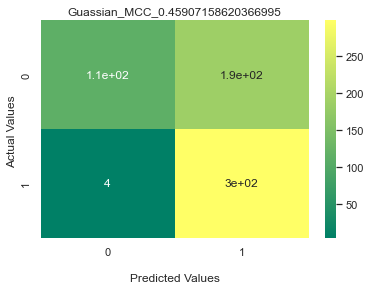

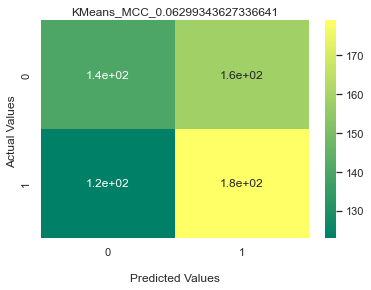

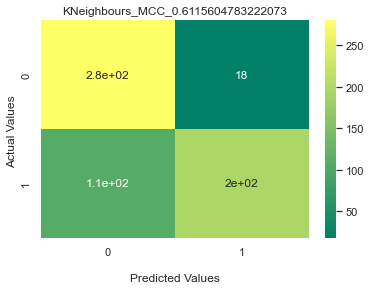

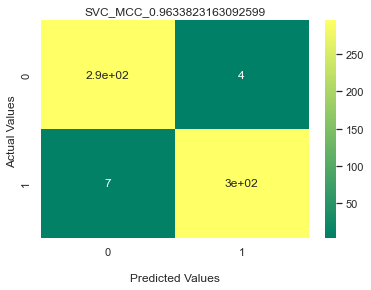

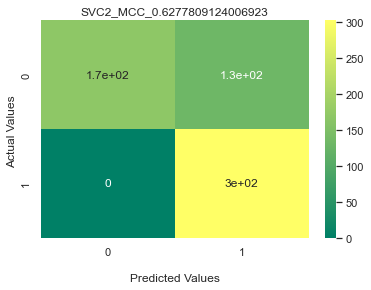

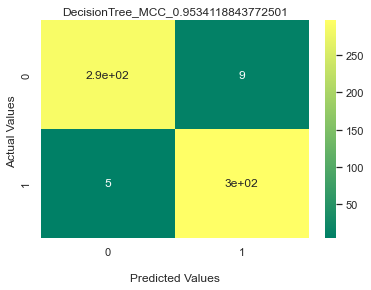

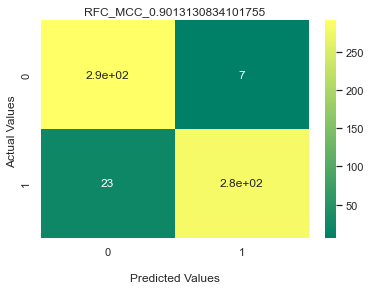

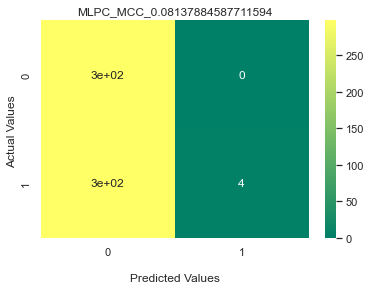

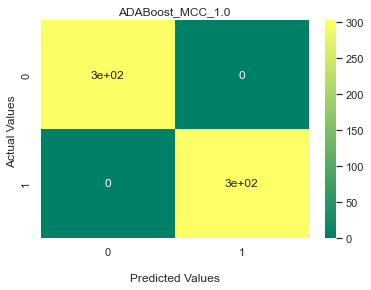

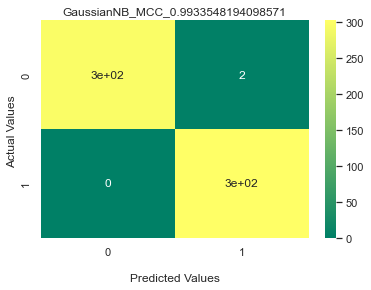

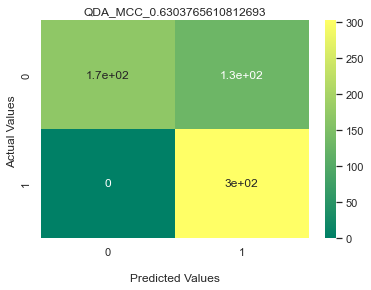

In [36]:
scores = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train,y_train)
    y_predict1 = clf_1.predict(X_test)
    scoring = matthews_corrcoef(y_test, y_predict1)
    scores.append(scoring)     
    cf_matrix1 = confusion_matrix(y_test, y_predict1)
    ax1 = sns.heatmap(cf_matrix1, annot=True, cmap='summer')
    title = str(str(i) + "_MCC_"+str(scoring))
    ax1.set_title(title);
    ax1.set_xlabel('\nPredicted Values')
    ax1.set_ylabel('Actual Values ');
    plt.show()


We may now plot our MCC scores by classifier to see which performed best.

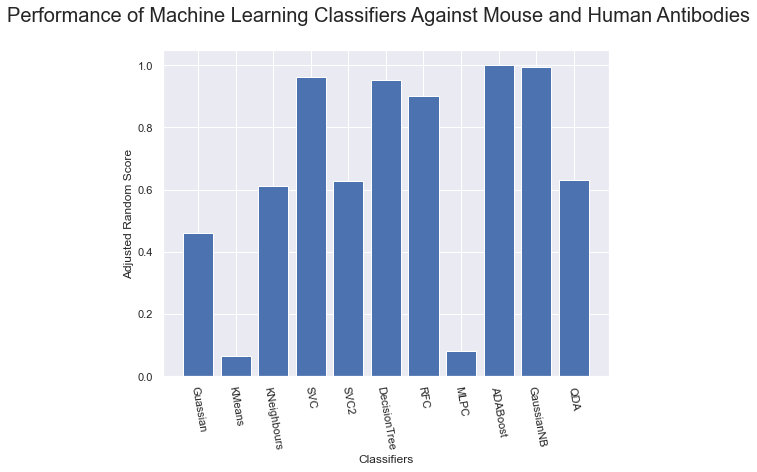

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(scores)), scores)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

As an extra task, we ma try dimensionality reduction to see if that improves the performance of poorer predictors.

In [42]:
nComp = 50 # Number of PCs to be returned
#trainIndx = np.random.binomial(1,0.9,size=filectr)

threshold = 0.999999


EncodingPCA = PCA(n_components=nComp, whiten=True)
EncodingPCA = EncodingPCA.fit(dataset)

cumExpVar = np.cumsum(EncodingPCA.explained_variance_ratio_)
keepPC = [pc for pc in range(nComp) if cumExpVar[pc]>=threshold][0]

NewEncodingPCA = EncodingPCA.transform(dataset)[:,range(keepPC)]
print(NewEncodingPCA.shape)



(2000, 25)


In [43]:

X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(NewEncodingPCA, y, test_size=.3, random_state=RANDOM_SEED, shuffle=True)
num_rows, num_cols = dataset.shape
print("Training set size: ", X_train.shape, "       Test set size: ", X_test.shape)


Training set size:  (1400, 890)        Test set size:  (600, 890)


GaussianMixture(n_components=2) 0.2958628831585772
KMeans(n_clusters=2) -0.2819096325768267
KNeighborsClassifier(n_neighbors=2) 0.9575762970793391
SVC(C=0.025, kernel='linear') 0.9933330370238678
SVC(C=1, gamma=2) 0.6958781298050537
DecisionTreeClassifier(max_depth=5) 0.7693821040657229
RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10) 0.8236610498483927
MLPClassifier(alpha=1, max_iter=1000) 0.9966719822499309
AdaBoostClassifier() 0.933525949402444
GaussianNB() 0.8086324567745858
QuadraticDiscriminantAnalysis() 0.9799991110716032


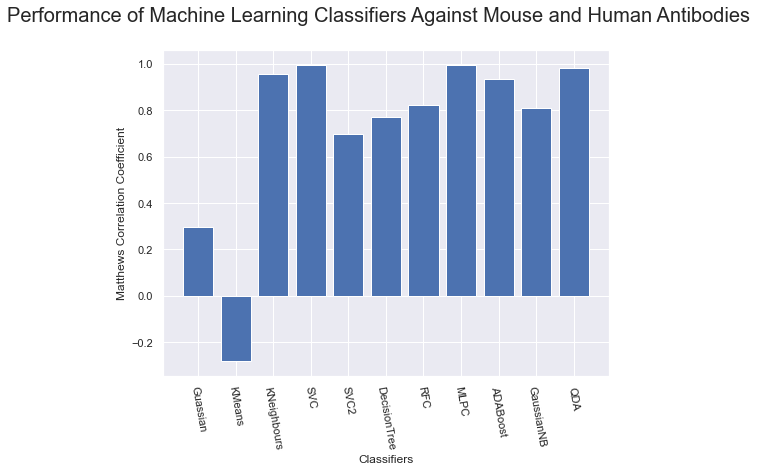

In [45]:
scores_PCA = []
for i in classifiers:
    clf_1 = classifiers.get(i)
    clf_1.fit(X_train_PCA,y_train_PCA)
    y_predict1 = clf_1.predict(X_test_PCA)
    scoring = matthews_corrcoef(y_test_PCA, y_predict1)
    scores_PCA.append(scoring)
    print(clf_1, scoring)
    plt.show()

fig, ax = plt.subplots(figsize=(8,6))
plt.suptitle('Performance of Machine Learning Classifiers Against Mouse and Human Antibodies', fontsize=20)

bins = arange(len(classifiers))
ax.bar(arange(len(scores_PCA)), scores_PCA)
ax.set_ylabel('Matthews Correlation Coefficient')
ax.set_xlabel('Classifiers')
ax.set_xticks(bins)
ax.set_xticklabels(classifiers, rotation=-80);

PCAs are also useful for visualising a highly dimensional dataset.

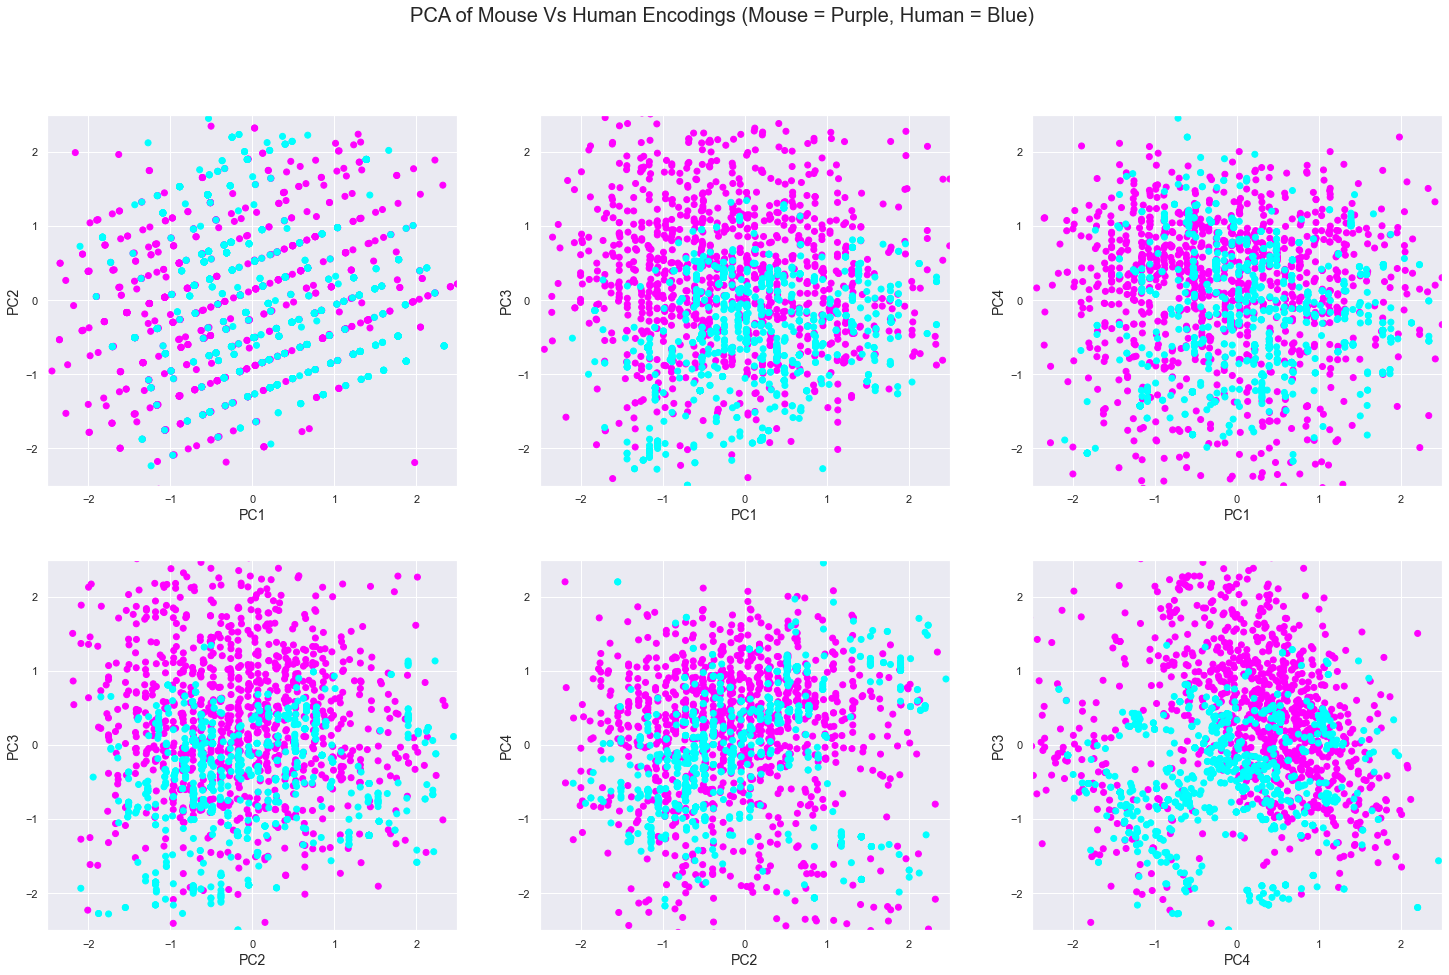

In [40]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))
plt.suptitle('PCA of Mouse Vs Human Encodings (Mouse = Purple, Human = Blue)', fontsize=20)

ax[0, 0].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,1], c=y, cmap='cool');
ax[0, 0].set_xlabel('PC1', fontsize=14); ax[0, 0].set_xlim([-2.5,2.5]);
ax[0, 0].set_ylabel('PC2', fontsize=14); ax[0, 0].set_ylim([-2.5,2.5]);


ax[0, 1].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[0, 1].set_xlabel('PC1', fontsize=14); ax[0, 1].set_xlim([-2.5,2.5]);
ax[0, 1].set_ylabel('PC3', fontsize=14); ax[0, 1].set_ylim([-2.5,2.5]);


ax[0, 2].scatter(NewEncodingPCA[:,0], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[0, 2].set_xlabel('PC1', fontsize=14); ax[0, 2].set_xlim([-2.5,2.5]);
ax[0, 2].set_ylabel('PC4', fontsize=14); ax[0, 2].set_ylim([-2.5,2.5]);


ax[1, 0].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 0].set_xlabel('PC2', fontsize=14); ax[1, 0].set_xlim([-2.5,2.5]);
ax[1, 0].set_ylabel('PC3', fontsize=14); ax[1, 0].set_ylim([-2.5,2.5]);


ax[1, 1].scatter(NewEncodingPCA[:,1], NewEncodingPCA[:,3], c=y, cmap='cool');
ax[1, 1].set_xlabel('PC2', fontsize=14); ax[1, 1].set_xlim([-2.5,2.5]);
ax[1, 1].set_ylabel('PC4', fontsize=14); ax[1, 1].set_ylim([-2.5,2.5]);


ax[1, 2].scatter(NewEncodingPCA[:,3], NewEncodingPCA[:,2], c=y, cmap='cool');
ax[1, 2].set_xlabel('PC4', fontsize=14); ax[1, 2].set_xlim([-2.5,2.5]);
ax[1, 2].set_ylabel('PC3', fontsize=14); ax[1, 2].set_ylim([-2.5,2.5]);


